# *Monod* demonstration: distinguishing models of transcriptional variation

We ran the *Monod* inference pipeline on thirteen datasets: pre-clustered mouse brain cell data, disaggregated into GABAergic and glutamatergic cell types, and five 10X Genomics mouse tissue samples. Each dataset was fit using the bursty, constitutive, extrinsic, and CIR models for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given maximum likelihood estimates under each model, we can apply the standard Akaike Information Criterion framework to attempt to assign probabilities to the models. These estimates are necessarily incomplete, as they do not take into account the parameter uncertainties; further, they appear to overestimate confidence in model selections. However, this is an essential first step toward exploring model ensembles. 

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()

In [2]:
from preprocess import *
from extract_data import extract_data
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *


In [3]:
models = ('Bursty','Extrinsic','CIR')
n_models = len(models)

In [4]:
n_models = len(models)

In [5]:
dataset_meta = ['B08','C01','F08','H12']
subcluster_names = ['l23it','l5it','l6it','l5et', 'l56np', 'l6ct', 'l6b']
cluster_names = ['gaba','glu']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] 

dir_string = './fits/gg_220602_022_allen_celltypes_1'
n_datasets = len(dataset_names)


In [6]:
dir_string = './fits/gg_220602_022_allen_celltypes_1'
result_strings = [[dir_string+'/'+x+'/'+y+'_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names] \
                  for y in models]
sd_strings = [dir_string+'/'+x+'/raw.sd' for x in dataset_names]

# res = [dir_string1+'/'+x for x in dn1]

# dn2 =  ['heart_1k','heart_10k','neuron_1k','neuron_10k','brain_5k']
# dn2 = [x+'_v3' for x in dn2]
# dataset_names = dn1 + dn2

# dir_string2 = './fits/gg_220526_021_modelcomp_1'
# res += [dir_string2+'/'+x for x in dn2]

# result_strings = [[x+'/'+model+'_Poisson_20x21/grid_scan_results.res' for model in models] for x in res]

# sd_strings = [dir_string1+'/'+x+'/raw.sd' for x in dn1] + [dir_string2+'/'+x+'/raw.sd' for x in dn2]


In [7]:
result_strings

[['./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l6it/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l5et/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l56np/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l6ct/Bursty_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l6b/Bursty_Poisson_20x21/grid_scan_results_upd.res'],
 ['./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res',
  './fits/gg_220602_022_allen_celltyp

In [8]:
sr_arr = []
sd_arr = []


for j in range(n_datasets):
    sd = load_search_data(sd_strings[j])
    sr_ = []
    for k in range(n_models):
        sr_.append(load_search_results(result_strings[k][j]))
    
    sd_arr.append(sd)
    sr_arr.append(sr_)


INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l23it/CIR_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5it/Extrinsic_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_l5

In [9]:
len(sr_arr)

7

## AIC weight computation

Now, we iterate over the results for all of the models, identify the parameter optima, and compute Akaike weights according to the procedure in Burnham and Anderson (2002).

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l23it.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l5it.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6it.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l5et.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l56np.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6ct.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6b.png.


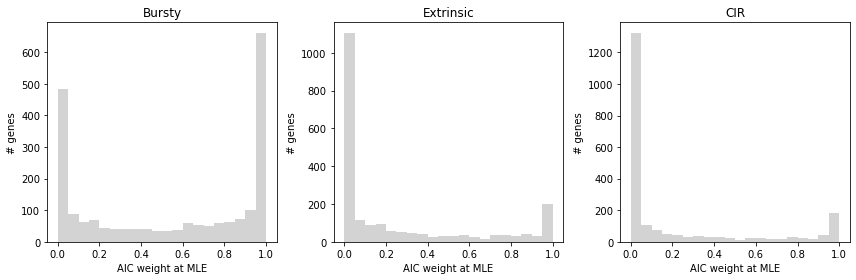

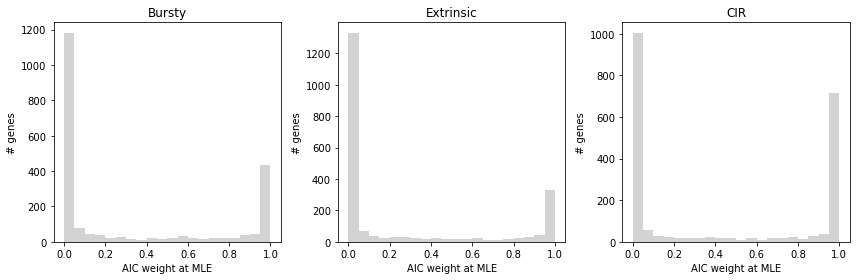

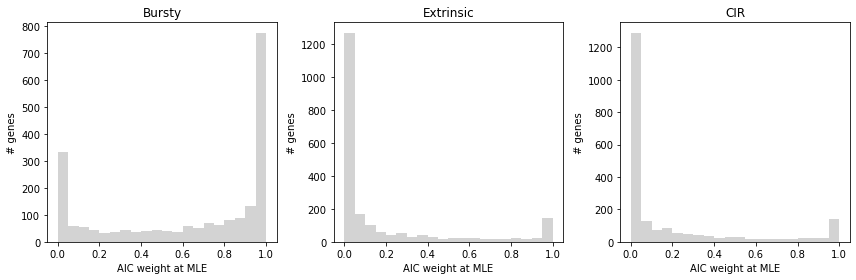

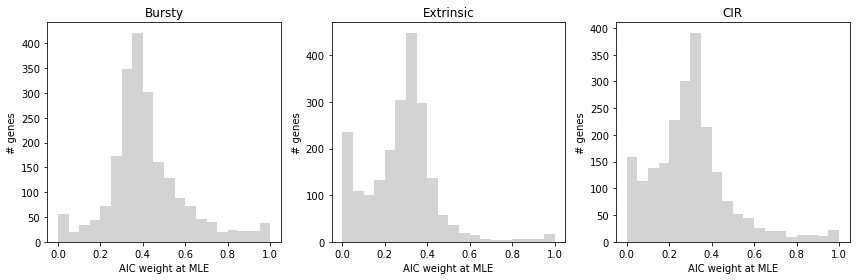

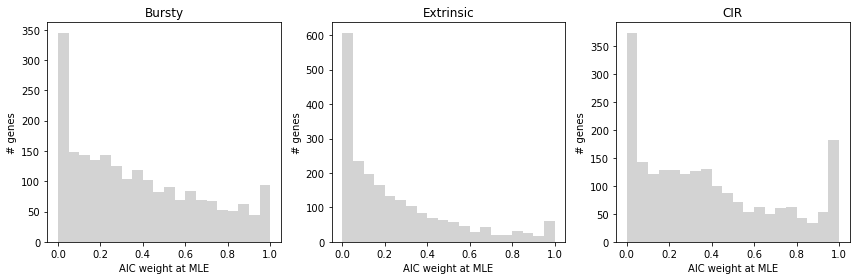

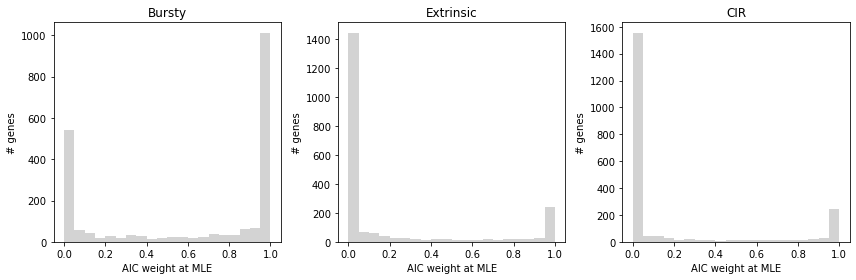

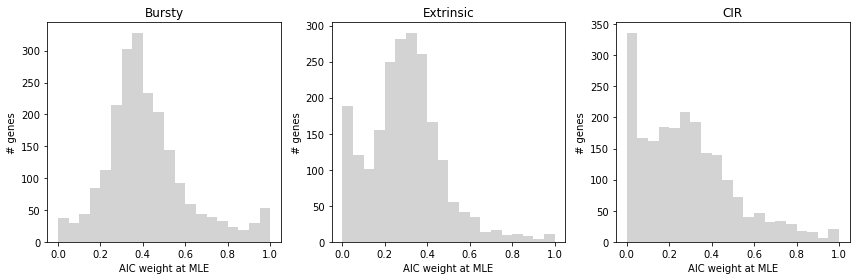

In [10]:
w = []

for j in range(n_datasets):
#     rs = result_strings[j]
    
#     sd = load_search_data(sd_strings[j])
    
#     sr_arr = []
#     for k in range(n_models):
#         sr = load_search_results(rs[k])
#         sr.find_sampling_optimum()
#         sr_arr.append(sr)
    
#     if j<len(dn1):
#         make_batch_analysis_dir(sr_arr,dir_string1)
#     else:
#         make_batch_analysis_dir(sr_arr,dir_string2)

    w_ = plot_AIC_weights(sr_arr[j],sd_arr[j],models,meta=dataset_names[j],savefig=True)
    w.append(w_)

We find that the constitutive model is essentially never selected as the optimal one; biological overdispersion is clearly mandatory to describe scRNA-seq joint distributions. However, surprisingly, we find quite a bit of variation in *which* overdispersed model is optimal.

In [11]:
w = np.asarray(w)

In [12]:
w.shape

(7, 3, 2130)

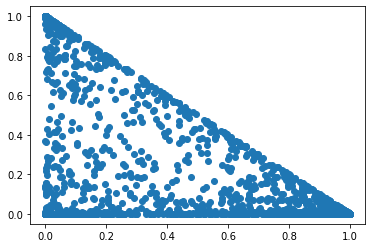

In [13]:
plt.scatter(w[0,0],w[0,2])

In [14]:
!pip install plotly

In [15]:
!pip install python-ternary

In [17]:
# import importlib
# importlib.reload(plotly)

In [18]:
import plotly
import plotly.express as px
import pandas as pd

In [19]:
import ternary


In [104]:
np.asarray([x.n_cells for x in sd_arr])

array([ 621, 1702,  471,   57,  191, 1359,   34])

In [151]:
gf_cir = (w[:,2,:]>0.8).all(0)

In [152]:
gn = sd_arr[0].gene_names

In [153]:
gn[gf_cir]

array(['Cox6b1', 'Mdh1', 'Slc24a3', 'Stmn3'], dtype='<U16')

In [154]:
sr_arr[0]

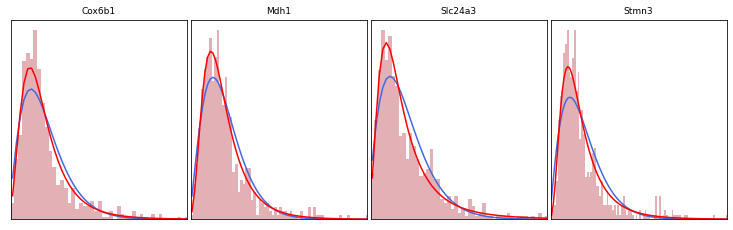

In [158]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][2]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_cir,sz=(1,4),figsize=(10,3),
                           marg='mature')

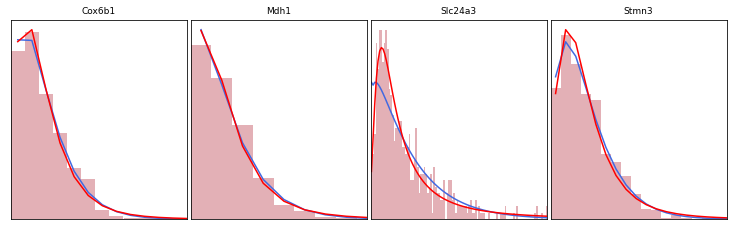

In [160]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][2]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_cir,sz=(1,4),figsize=(10,3),
                          marg='nascent')

In [191]:
gf_burst = (w[:,0,:]>0.6).all(0)

In [192]:
gn[gf_burst]

array(['Atxn1', 'D430041D05Rik', 'Gria2', 'Igf1r', 'Nfasc', 'Rbfox3',
       'Rims1', 'Sez6l', 'Slc35f1', 'Trhde'], dtype='<U16')

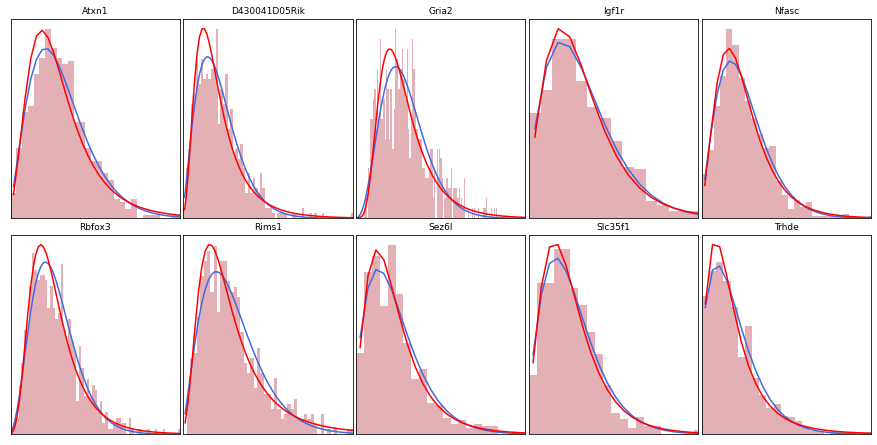

In [197]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][2]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_burst,sz=(2,5),figsize=(12,6),
                           marg='mature')

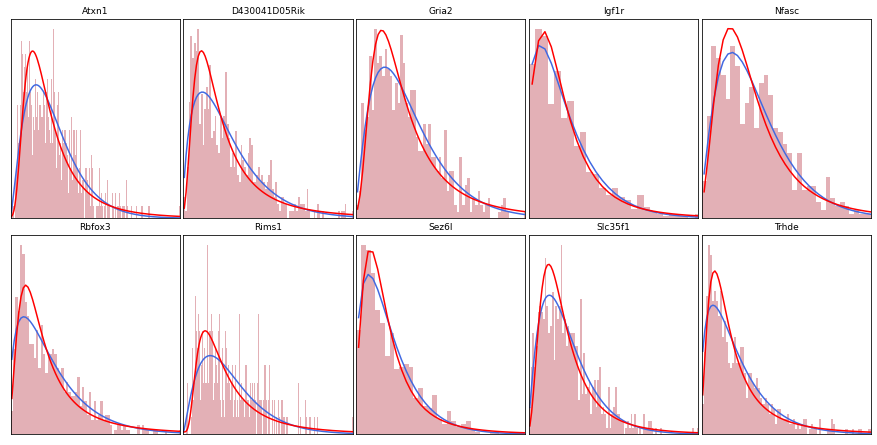

In [196]:
compare_gene_distributions([sr_arr[0][0],sr_arr[0][2]],[sd_arr[0],sd_arr[0]],genes_to_plot=gf_burst,sz=(2,5),figsize=(12,6),
                           marg='nascent')

In [20]:
n_cells = np.asarray([x.n_cells for x in sd_arr])
n_cells = n_cells/n_cells.sum()
w_mean = (w*n_cells[:,None,None]).sum(0)

In [21]:
w_mean.shape

(3, 2130)

In [22]:
df = pd.DataFrame(data={models[k]:w_mean[k] for k in range(len(models))} )

In [23]:
df

,Bursty,Extrinsic,CIR
0,0.939079,0.013615,0.047305
1,0.765029,0.103356,0.131615
2,0.559727,0.009291,0.430982
3,0.201107,0.794175,0.004718
4,0.459532,0.057437,0.483031
...,...,...,...
2125,0.007646,0.627067,0.365287
2126,0.039728,0.955695,0.004577
2127,0.091669,0.014163,0.894169
2128,0.586675,0.013617,0.399708


In [33]:
w_mean.min()

1.7005909108799088e-09

In [102]:
fig = px.scatter_ternary(df,a=models[0],b=models[1],c=models[2])
fig.show()

In [26]:
import plotly.figure_factory as ff


In [78]:
kde = scipy.stats.gaussian_kde(w_mean[:2],bw_method=0.1)

In [79]:
np.vstack((a,b)).shape

(2, 210)

In [80]:
kde([0,1])

array([3.64628118])

In [100]:
a, b = np.mgrid[0:1:20j, 0:1:20j]
mask = a + b <= 1
a = a[mask].ravel()
b = b[mask].ravel()
c = 1 - a - b
# Values to be displayed as contours
# z = a * b * c
z=kde(np.vstack((a,b)))
fig = ff.create_ternary_contour(np.stack((a, b, c)), z,ncontours=6,colorscale='Cividis',pole_labels=models,\
                               coloring=None)
fig.show()


In [52]:
a, b = np.mgrid[0:1:20j, 0:1:20j]
mask = a + b <= 1
a = a[mask].ravel()
b = b[mask].ravel()
c = 1 - a - b


In [60]:
mask.shape

(20, 20)